# Introduction and Setup

This notebook utilizes a CycleGAN architecture to add Monet-style to photos. For this tutorial, we will be using the TFRecord dataset. Import the following packages and change the accelerator to TPU.

For more information, check out [TensorFlow](https://www.tensorflow.org/tutorials/generative/cyclegan) and [Keras](https://keras.io/examples/generative/cyclegan/) CycleGAN documentation pages.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Number of replicas: 1
2.6.4


# Load in the data

We want to keep our photo dataset and our Monet dataset separate. First, load in the filenames of the TFRecords.

In [2]:
GCS_PATH = KaggleDatasets().get_gcs_path()

In [3]:
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

2022-07-07 01:59:07.896000: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "Not found: Could not locate the credentials file.". Retrieving token from GCE failed with "Failed precondition: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Monet TFRecord Files: 5
Photo TFRecord Files: 20


All the images for the competition are already sized to 256x256. As these images are RGB images, set the channel to 3. Additionally, we need to scale the images to a [-1, 1] scale. Because we are building a generative model, we don't need the labels or the image id so we'll only return the image from the TFRecord.

In [4]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

Define the function to extract the image from the files.

In [5]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

Let's load in our datasets.

In [6]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

2022-07-07 01:59:08.384490: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-07 01:59:08.498191: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-07 01:59:08.499049: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-07 01:59:08.500329: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [7]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

2022-07-07 01:59:11.248826: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Let's  visualize a photo example and a Monet example.

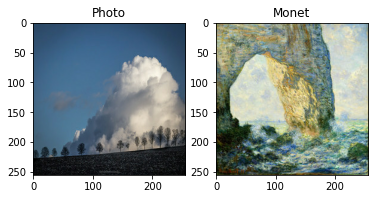

In [8]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

In [9]:
OUTPUT_CHANNELS = 3

Let's build our generator!

The generator first downsamples the input image and then upsample while establishing long skip connections. Skip connections are a way to help bypass the vanishing gradient problem by concatenating the output of a layer to multiple layers instead of only one. Here we concatenate the output of the downsample layer to the upsample layer in a symmetrical fashion.

In [10]:
def _get_norm_layer(norm):
    if norm == 'none':
        return lambda: lambda x: x
    elif norm == 'batch_norm':
        return keras.layers.BatchNormalization
    elif norm == 'instance_norm':
        return tfa.layers.InstanceNormalization
    elif norm == 'layer_norm':
        return keras.layers.LayerNormalization


def ResnetGenerator(input_shape=(256, 256, 3),
                    output_channels=3,
                    dim=64,
                    n_downsamplings=2,
                    n_blocks=9,
                    norm='instance_norm'):
    Norm = _get_norm_layer(norm)

    def _residual_block(x):
        dim = x.shape[-1]
        h = x

        h = tf.pad(h, [[0, 0], [1, 1], [1, 1], [0, 0]], mode='REFLECT')
        h = keras.layers.Conv2D(dim, 3, padding='valid', use_bias=False)(h)
        h = Norm()(h)
        h = tf.nn.relu(h)

        h = tf.pad(h, [[0, 0], [1, 1], [1, 1], [0, 0]], mode='REFLECT')
        h = keras.layers.Conv2D(dim, 3, padding='valid', use_bias=False)(h)
        h = Norm()(h)

        return keras.layers.add([x, h])

    # 0
    h = inputs = keras.Input(shape=input_shape)

    # 1
    h = tf.pad(h, [[0, 0], [3, 3], [3, 3], [0, 0]], mode='REFLECT')
    h = keras.layers.Conv2D(dim, 7, padding='valid', use_bias=False)(h)
    h = Norm()(h)
    h = tf.nn.relu(h)

    # 2
    for _ in range(n_downsamplings):
        dim *= 2
        h = keras.layers.Conv2D(dim, 3, strides=2, padding='same', use_bias=False)(h)
        h = Norm()(h)
        h = tf.nn.relu(h)

    # 3
    for _ in range(n_blocks):
        h = _residual_block(h)

    # 4
    for _ in range(n_downsamplings):
        dim //= 2
        h = keras.layers.Conv2DTranspose(dim, 3, strides=2, padding='same', use_bias=False)(h)
        h = Norm()(h)
        h = tf.nn.relu(h)

    # 5
    h = tf.pad(h, [[0, 0], [3, 3], [3, 3], [0, 0]], mode='REFLECT')
    h = keras.layers.Conv2D(output_channels, 7, padding='valid')(h)
    h = tf.tanh(h)

    return keras.Model(inputs=inputs, outputs=h)


# Build the discriminator

The discriminator takes in the input image and classifies it as real or fake (generated). Instead of outputing a single node, the discriminator outputs a smaller 2D image with higher pixel values indicating a real classification and lower values indicating a fake classification.

In [11]:
def ConvDiscriminator(input_shape=(256, 256, 3),
                      dim=64,
                      n_downsamplings=3,
                      norm='instance_norm'):
    dim_ = dim
    Norm = _get_norm_layer(norm)

    # 0
    h = inputs = keras.Input(shape=input_shape)

    # 1
    h = keras.layers.Conv2D(dim, 4, strides=2, padding='same')(h)
    h = tf.nn.leaky_relu(h, alpha=0.2)

    for _ in range(n_downsamplings - 1):
        dim = min(dim * 2, dim_ * 8)
        h = keras.layers.Conv2D(dim, 4, strides=2, padding='same', use_bias=False)(h)
        h = Norm()(h)
        h = tf.nn.leaky_relu(h, alpha=0.2)

    # 2
    dim = min(dim * 2, dim_ * 8)
    h = keras.layers.Conv2D(dim, 4, strides=1, padding='same', use_bias=False)(h)
    h = Norm()(h)
    h = tf.nn.leaky_relu(h, alpha=0.2)

    # 3
    h = keras.layers.Conv2D(1, 4, strides=1, padding='same')(h)

    return keras.Model(inputs=inputs, outputs=h)


# Learning Rate Scheduler

In [12]:
class LinearDecay(keras.optimizers.schedules.LearningRateSchedule):
    # if `step` < `step_decay`: use fixed learning rate
    # else: linearly decay the learning rate to zero

    def __init__(self, initial_learning_rate, total_steps, step_decay):
        super(LinearDecay, self).__init__()
        self._initial_learning_rate = initial_learning_rate
        self._steps = total_steps
        self._step_decay = step_decay
        self.current_learning_rate = tf.Variable(initial_value=initial_learning_rate, trainable=False, dtype=tf.float32)

    def __call__(self, step):
        self.current_learning_rate.assign(tf.cond(
            step >= self._step_decay,
            true_fn=lambda: self._initial_learning_rate * (1 - 1 / (self._steps - self._step_decay) * (step - self._step_decay)),
            false_fn=lambda: self._initial_learning_rate
        ))
        return self.current_learning_rate

In [13]:
with strategy.scope():
    #monet_generator = Generator() # transforms photos to Monet-esque paintings
    #photo_generator = Generator() # transforms Monet paintings to be more like photos

    #monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    #photo_discriminator = Discriminator() # differentiates real photos and generated photos
    
    monet_generator = ResnetGenerator() # transforms photos to Monet-esque paintings
    photo_generator = ResnetGenerator() # transforms Monet paintings to be more like photos

    monet_discriminator = ConvDiscriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = ConvDiscriminator() # differentiates real photos and generated photos
    
    
    
    
    

Since our generators are not trained yet, the generated Monet-esque photo does not show what is expected at this point.

2022-07-07 01:59:15.912005: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


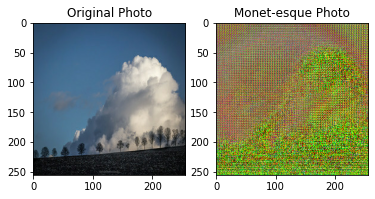

In [14]:
to_monet = monet_generator(example_photo)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

# Build the CycleGAN model

We will subclass a `tf.keras.Model` so that we can run `fit()` later to train our model. During the training step, the model transforms a photo to a Monet painting and then back to a photo. The difference between the original photo and the twice-transformed photo is the cycle-consistency loss. We want the original photo and the twice-transformed photo to be similar to one another.

The losses are defined in the next section.

In [15]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

# Define loss functions

The discriminator loss function below compares real images to a matrix of 1s and fake images to a matrix of 0s. The perfect discriminator will output all 1s for real images and all 0s for fake images. The discriminator loss outputs the average of the real and generated loss.

In [16]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

The generator wants to fool the discriminator into thinking the generated image is real. The perfect generator will have the discriminator output only 1s. Thus, it compares the generated image to a matrix of 1s to find the loss.

In [17]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

We want our original photo and the twice transformed photo to be similar to one another. Thus, we can calculate the cycle consistency loss be finding the average of their difference.

In [18]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

The identity loss compares the image with its generator (i.e. photo with photo generator). If given a photo as input, we want it to generate the same image as the image was originally a photo. The identity loss compares the input with the output of the generator.

In [19]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

# Train the CycleGAN

Let's compile our model. Since we used `tf.keras.Model` to build our CycleGAN, we can just ude the `fit` function to train our model.

In [20]:
import re
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

n_monet_samples = count_data_items(MONET_FILENAMES)
n_photo_samples = count_data_items(PHOTO_FILENAMES)

print(f'Monet TFRecord files: {len(MONET_FILENAMES)}')
print(f'Monet image files: {n_monet_samples}')
print(f'Photo TFRecord files: {len(PHOTO_FILENAMES)}')
print(f'Photo image files: {n_photo_samples}')

Monet TFRecord files: 5
Monet image files: 300
Photo TFRecord files: 20
Photo image files: 7038


In [21]:
with strategy.scope():
    #monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    #photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    #monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    #photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    
    lr = 2e-4
    beta_1 = 0.5
    len_dataset = n_photo_samples
    EPOCHS=20
    
    GA_lr_scheduler = LinearDecay(lr, EPOCHS * len_dataset, EPOCHS // 2 * len_dataset)
    DA_lr_scheduler = LinearDecay(lr, EPOCHS * len_dataset, EPOCHS // 2 * len_dataset)
    GB_lr_scheduler = LinearDecay(lr, EPOCHS * len_dataset, EPOCHS // 2 * len_dataset)
    DB_lr_scheduler = LinearDecay(lr, EPOCHS * len_dataset, EPOCHS // 2 * len_dataset)
    
    monet_discriminator_optimizer = keras.optimizers.Adam(learning_rate=GA_lr_scheduler, beta_1=beta_1)
    photo_discriminator_optimizer = keras.optimizers.Adam(learning_rate=DA_lr_scheduler, beta_1=beta_1)

    monet_generator_optimizer = keras.optimizers.Adam(learning_rate=GB_lr_scheduler, beta_1=beta_1)
    photo_generator_optimizer = keras.optimizers.Adam(learning_rate=DB_lr_scheduler, beta_1=beta_1)

    


In [22]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [23]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=100
)

Epoch 1/100
300/300 [==============================] - 183s 408ms/step - monet_gen_loss: 9.1870 - photo_gen_loss: 9.2824 - monet_disc_loss: 0.6262 - photo_disc_loss: 0.6401
Epoch 2/100
300/300 [==============================] - 122s 406ms/step - monet_gen_loss: 8.7746 - photo_gen_loss: 8.7878 - monet_disc_loss: 0.5787 - photo_disc_loss: 0.5642
Epoch 3/100
300/300 [==============================] - 122s 407ms/step - monet_gen_loss: 8.1187 - photo_gen_loss: 8.1272 - monet_disc_loss: 0.5797 - photo_disc_loss: 0.5654
Epoch 4/100
300/300 [==============================] - 122s 406ms/step - monet_gen_loss: 8.2203 - photo_gen_loss: 8.4834 - monet_disc_loss: 0.5790 - photo_disc_loss: 0.5344
Epoch 5/100
300/300 [==============================] - 122s 406ms/step - monet_gen_loss: 7.8727 - photo_gen_loss: 8.1335 - monet_disc_loss: 0.5665 - photo_disc_loss: 0.5240
Epoch 6/100
300/300 [==============================] - 122s 406ms/step - monet_gen_loss: 7.6527 - photo_gen_loss: 7.8198 - monet_disc_l

# Visualize our Monet-esque photos

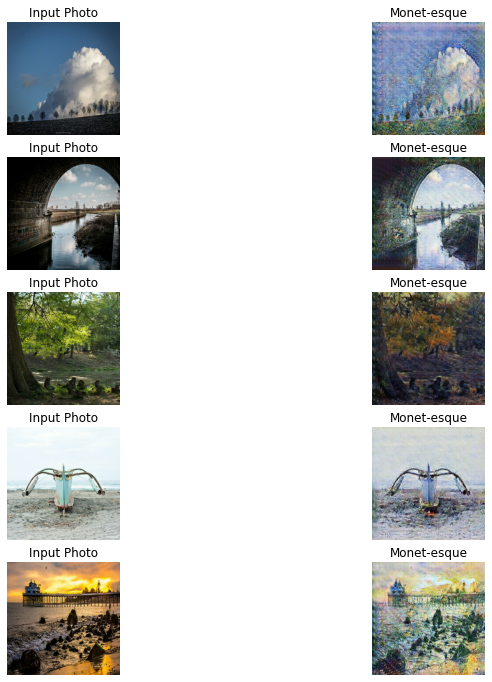

In [24]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

# Create submission file

In [25]:
import PIL
! mkdir ../images

In [26]:
i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    print(i)
    i += 1

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [27]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'